<a href="https://colab.research.google.com/github/Dongjin-1203/Study-code/blob/main/NLP_%EC%8B%A4%EC%8A%B5(IMDB)_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP 실습: 영화 리뷰 감정분석(IMDB)

인터넷 영화 데이터베이스(Internet Movie Database)로부터 가져온 양극단의 리뷰 5만 개로 이루어진 IMDB 데이터셋을 사용하겠습니다.2 이 데이터셋은 훈련 데이터 2만 5,000개와 테스트 데이터 2만 5,000개로 나뉘어 있고 각각 50%는 부정, 50%는 긍정 리뷰로 구성되어 있습니다.
출처: https://thebook.io/080315/0182/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

# 데이터 불러오기

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [5]:
# IMDB 데이터 다운로드
from datasets import load_dataset
imdb = load_dataset("imdb")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
# DataFrame으로 변환
train_df = pd.DataFrame(imdb['train'])
test_df = pd.DataFrame(imdb['test'])

In [7]:
train_df.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


# 데이터 탐색 및 분석

In [8]:
# 기본 정보
print(f"📋 기본 정보:")
print(f"   컬럼: {list(train_df.columns)}")     # 컬럼: ['text', 'label']
print(f"   훈련 데이터 크기: {train_df.shape}")     # 훈련 데이터 크기: (25000, 2)
print(f"   테스트 데이터 크기: {test_df.shape}")    # 테스트 데이터 크기: (25000, 2)

📋 기본 정보:
   컬럼: ['text', 'label']
   훈련 데이터 크기: (25000, 2)
   테스트 데이터 크기: (25000, 2)


text, label 칼럼으로 이뤄져 있고 훈련 테스트 모두 25000개의 데이터가 있다.

In [9]:
# 레이블 분포
print(f"\n📊 감정 레이블 분포:")
label_counts = train_df['label'].value_counts().sort_index()    # 인덱스 기준(sort_index())으로 value를 세
for label, count in label_counts.items():
    sentiment = "Positive" if label == 1 else "Negative"    # 긍정리뷰와 부정리뷰로 매핑
    percentage = count / len(train_df) * 100
    print(f"   {sentiment} ({label}): {count:,}개 ({percentage:.1f}%)")


📊 감정 레이블 분포:
   Negative (0): 12,500개 (50.0%)
   Positive (1): 12,500개 (50.0%)


In [10]:
# 텍스트 길이 분석
train_df['text_length'] = train_df['text'].str.len()
train_df['word_count'] = train_df['text'].str.split().str.len()

In [11]:
print(train_df['text'].str.len())
# .str: 문자열 접근자 - pandas에서 문자열 메서드를 사용하기 위한 접근자
# .len(): 각 문자열의 길이(문자 개수)를 계산

0        1640
1        1294
2         528
3         706
4        1814
         ... 
24995     637
24996    1091
24997     740
24998    4066
24999     319
Name: text, Length: 25000, dtype: int64


In [12]:
print(f"\n📏 텍스트 통계:")
print(f"   평균 글자 수: {train_df['text_length'].mean():.0f}")
print(f"   평균 단어 수: {train_df['word_count'].mean():.0f}")
print(f"   최대 글자 수: {train_df['text_length'].max():,}")
print(f"   최소 글자 수: {train_df['text_length'].min()}")


📏 텍스트 통계:
   평균 글자 수: 1325
   평균 단어 수: 234
   최대 글자 수: 13,704
   최소 글자 수: 52


# 샘플 데이터 탐색 시각화

In [13]:
n_samples=5

for i in range(n_samples):
    text = train_df.iloc[i]['text']
    label = train_df.iloc[i]['label']
    sentiment = "😊 Positive" if label == 1 else "😞 Negative"

    # 텍스트가 너무 길면 앞부분만 표시
    display_text = text[:200] + "..." if len(text) > 200 else text

    print(f"\n📄 Sample {i+1}:")
    print(f"   감정: {sentiment}")
    print(f"   리뷰: {display_text}")
    print(f"   길이: {len(text)}자, {len(text.split())}단어")


📄 Sample 1:
   감정: 😞 Negative
   리뷰: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev...
   길이: 1640자, 288단어

📄 Sample 2:
   감정: 😞 Negative
   리뷰: "I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that ...
   길이: 1294자, 214단어

📄 Sample 3:
   감정: 😞 Negative
   리뷰: If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches ...
   길이: 528자, 93단어

📄 Sample 4:
   감정: 😞 Negative
   리뷰: This film was probably inspired by Godard's Masculin, féminin and I urge you to see that film instead.<br /><br />The film has two strong elements and those are, (1) the realisti

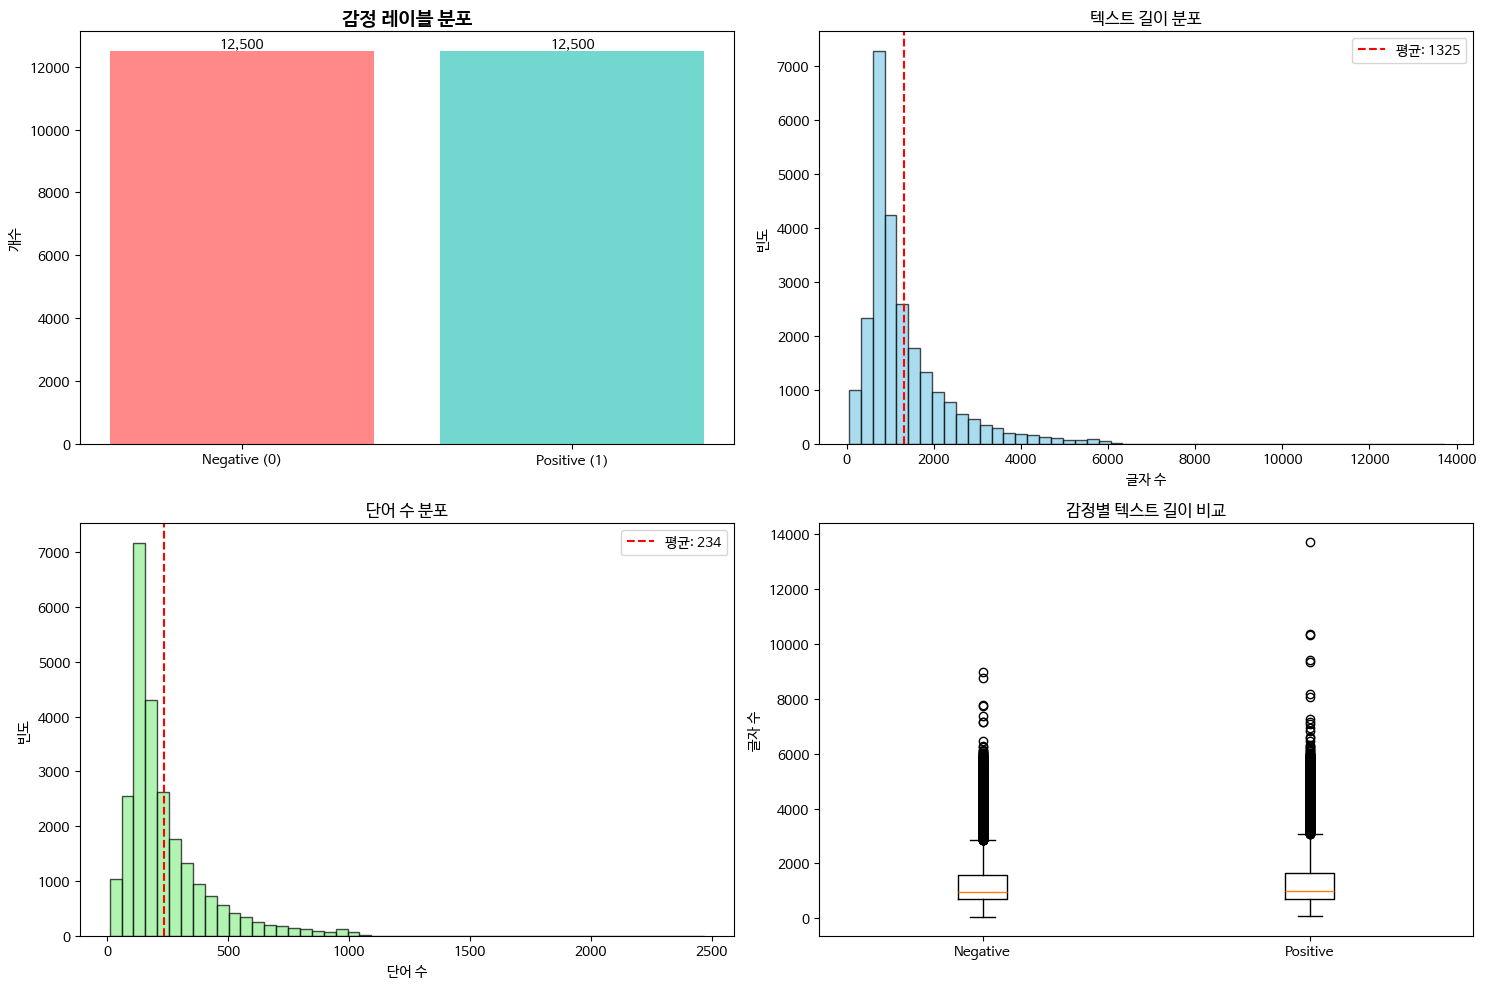

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. 감정 레이블 분포
label_counts = train_df['label'].value_counts().sort_index()
bars1 = axes[0, 0].bar(['Negative (0)', 'Positive (1)'], label_counts.values,
                        color=['#ff6b6b', '#4ecdc4'], alpha=0.8)
axes[0, 0].set_title('감정 레이블 분포', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('개수')

# 막대에 수치 표시
for bar in bars1:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}', ha='center', va='bottom')

# 2. 텍스트 길이 분포
axes[0, 1].hist(train_df['text_length'], bins=50, alpha=0.7, color='skyblue',
                edgecolor='black')
axes[0, 1].set_title('텍스트 길이 분포')
axes[0, 1].set_xlabel('글자 수')
axes[0, 1].set_ylabel('빈도')
axes[0, 1].axvline(train_df['text_length'].mean(), color='red', linestyle='--',
                    label=f'평균: {train_df["text_length"].mean():.0f}')
axes[0, 1].legend()

# 3. 단어 수 분포
axes[1, 0].hist(train_df['word_count'], bins=50, alpha=0.7, color='lightgreen',
                edgecolor='black')
axes[1, 0].set_title('단어 수 분포')
axes[1, 0].set_xlabel('단어 수')
axes[1, 0].set_ylabel('빈도')
axes[1, 0].axvline(train_df['word_count'].mean(), color='red', linestyle='--',
                    label=f'평균: {train_df["word_count"].mean():.0f}')
axes[1, 0].legend()

# 4. 감정별 평균 길이 비교
pos_lengths = train_df[train_df['label'] == 1]['text_length']
neg_lengths = train_df[train_df['label'] == 0]['text_length']

axes[1, 1].boxplot([neg_lengths, pos_lengths],
                    labels=['Negative', 'Positive'])
axes[1, 1].set_title('감정별 텍스트 길이 비교')
axes[1, 1].set_ylabel('글자 수')

plt.tight_layout()
plt.show()

빈도가 높은 단어 15개 출력

In [15]:
# 전체 단어 추출
top_n=15

all_words = []
for text in train_df['text']:
    words = text.lower().split()
    all_words.extend(words)

# 단어 빈도 계산
word_freq = Counter(all_words)
total_words = len(all_words)
unique_words = len(word_freq)

print(f"📈 전체 통계:")
print(f"   총 단어 수: {total_words:,}개")
print(f"   고유 단어 수: {unique_words:,}개")
print(f"   어휘 다양성: {unique_words/total_words:.4f}")

print(f"\n🔤 가장 빈번한 단어 Top {top_n}:")
for i, (word, freq) in enumerate(word_freq.most_common(top_n), 1):
    percentage = freq / total_words * 100
    print(f"   {i:2d}. {word:15s}: {freq:6,}회 ({percentage:.2f}%)")

📈 전체 통계:
   총 단어 수: 5,844,680개
   고유 단어 수: 251,637개
   어휘 다양성: 0.0431

🔤 가장 빈번한 단어 Top 15:
    1. the            : 322,198회 (5.51%)
    2. a              : 159,953회 (2.74%)
    3. and            : 158,572회 (2.71%)
    4. of             : 144,462회 (2.47%)
    5. to             : 133,967회 (2.29%)
    6. is             : 104,171회 (1.78%)
    7. in             : 90,527회 (1.55%)
    8. i              : 70,480회 (1.21%)
    9. this           : 69,714회 (1.19%)
   10. that           : 66,292회 (1.13%)
   11. it             : 65,505회 (1.12%)
   12. /><br          : 50,935회 (0.87%)
   13. was            : 47,024회 (0.80%)
   14. as             : 45,102회 (0.77%)
   15. for            : 42,843회 (0.73%)


/><br가 꽤 빈번하게 나오는 것을 확인했다.   
html 마크업 문법이거나 문장 사이 구분자 같다.   
※ 특정 문자가 있는 문장만 출력하는 구문이 있으면 좋을 것 같다.

'the' 나 'a'같은 관사가 많다. 자주 사용되는 언어긴 하나, 임베딩하는데 있어 방해요소로 생각된다.     
※ the를 많이 사용한다해서 특정 감정으로 분류되거나 하면 안된다.

__불필요 단어들은 제거하고 텍스트 정제 등의 전처리가 필요하다.__

# 결측값, 중복값, 공백, 극단값 확인

In [16]:
pd.set_option('display.max_colwidth', None)  # 칼럼 폭 제한 없음
find_br = train_df[train_df['text'].str.contains('/><br')]

In [17]:
find_br['text'].head(2)

,text
0,"I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered ""controversial"" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, even then it's not shot like some cheaply made porno. While my countrymen mind find it shocking, in reality sex and nudity are a major staple in Swedish cinema. Even Ingmar Bergman, arguably their answer to good old boy John Ford, had sex scenes in his films.<br /><br />I do commend the filmmakers for the fact that any sex shown in the film is shown for artistic purposes rather than just to shock people and make money to be shown in pornographic theaters in America. I AM CURIOUS-YELLOW is a good film for anyone wanting to study the meat and potatoes (no pun intended) of Swedish cinema. But really, this film doesn't have much of a plot."
2,"If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).<br /><br />One might better spend one's time staring out a window at a tree growing.<br /><br />"


In [18]:
print(find_br['text'].head(1))

0    I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between

하나의 리뷰에 문장이 여러개가 있는 것을 확인했다.

In [19]:
# 결측값 확인
missing_text = train_df['text'].isnull().sum()
missing_label = train_df['label'].isnull().sum()
print(f"📋 결측값:")
print(f"   텍스트: {missing_text}개")
print(f"   레이블: {missing_label}개")

📋 결측값:
   텍스트: 0개
   레이블: 0개


In [20]:
# 빈 텍스트 확인
empty_text = (train_df['text'].str.strip() == '').sum()
print(f"   빈 텍스트: {empty_text}개")

   빈 텍스트: 0개


In [21]:
# 중복 확인
duplicates = train_df.duplicated().sum()
print(f"   중복 데이터: {duplicates}개")

   중복 데이터: 96개


In [22]:
# 극단적으로 짧거나 긴 텍스트
very_short = (train_df['text_length'] < 50).sum()
very_long = (train_df['text_length'] > 5000).sum()
print(f"   매우 짧은 텍스트 (<50자): {very_short}개")
print(f"   매우 긴 텍스트 (>5000자): {very_long}개")

if missing_text == 0 and missing_label == 0 and empty_text == 0:
    print("   ✅ 데이터 품질 양호!")
else:
    print("   ⚠️ 데이터 전처리 필요")

   매우 짧은 텍스트 (<50자): 0개
   매우 긴 텍스트 (>5000자): 313개
   ✅ 데이터 품질 양호!


## 현재까지 파악한 것

1. 문장의 길이가 상당하다.
2. /><br가 있어 불용어 처리가 필요하다.
3. 관사나 불용어 같이 벡터화 하는데 방해되는 단어들이 많다.

__이러한 이유로 전처리가 필요한 것이다!!__

# 데이터 전처리 및 토큰화

## 데이터 전처리

In [23]:
import re
import string
# NLTK 라이브러리
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [24]:
# NLTK 데이터 다운로드 (최초 한 번만)
def download_nltk_data():
    """NLTK 필요 데이터 다운로드"""
    nltk_data = ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger', 'punkt_tab']

    for data in nltk_data:
        try:
            nltk.data.find(f'tokenizers/{data}' if data == 'punkt' or data == 'punkt_tab' else
                          f'corpora/{data}' if data in ['stopwords', 'wordnet'] else
                          f'taggers/{data}')
        except LookupError:
            print(f"📥 NLTK {data} 다운로드 중...")
            nltk.download(data, quiet=True)
    print("✅ 다운로드 완료!")

In [25]:
# NLTK 데이터 다운로드
download_nltk_data()

📥 NLTK punkt 다운로드 중...
📥 NLTK stopwords 다운로드 중...
📥 NLTK wordnet 다운로드 중...
📥 NLTK averaged_perceptron_tagger 다운로드 중...
📥 NLTK punkt_tab 다운로드 중...
✅ 다운로드 완료!


In [26]:
class IMDBPreprocessor:
    """IMDB 데이터 전용 전처리 클래스"""

    def __init__(self):
        # 도구 초기화
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

        # IMDB 특화 불용어 추가
        self.custom_stopwords = {
            'movie', 'film', 'movies', 'films', 'cinema', 'watch', 'watching',
            'watched', 'see', 'seen', 'show', 'series', 'episode', 'character',
            'characters', 'story', 'plot', 'scene', 'scenes', 'director',
            'actor', 'actress', 'acting', 'performance', 'cast', 'script',
            'one', 'two', 'would', 'could', 'should', 'also', 'get', 'go',
            'time', 'even', 'really', 'much', 'well', 'way', 'make', 'made',
            'take', 'year', 'years', 'end', 'first', 'last', 'good', 'bad'
        }
        self.stop_words.update(self.custom_stopwords)

        # 축약형 사전
        self.contractions = {
            "don't": "do not", "won't": "will not", "can't": "cannot",
            "n't": " not", "'re": " are", "'ve": " have", "'ll": " will",
            "'d": " would", "'m": " am", "it's": "it is", "that's": "that is",
            "there's": "there is", "here's": "here is", "what's": "what is",
            "where's": "where is", "who's": "who is", "how's": "how is",
            "let's": "let us", "i'm": "i am", "you're": "you are",
            "we're": "we are", "they're": "they are", "i've": "i have",
            "you've": "you have", "we've": "we have", "they've": "they have",
            "i'll": "i will", "you'll": "you will", "we'll": "we will",
            "they'll": "they will", "i'd": "i would", "you'd": "you would",
            "we'd": "we would", "they'd": "they would"
        }

    def clean_html(self, text):
        """HTML 태그 제거"""
        # IMDB 데이터에 특히 많은 <br /> 태그 제거
        text = re.sub(r'<br\s*/?>', ' ', text, flags=re.IGNORECASE)
        # 기타 HTML 태그 제거
        text = re.sub(r'<[^>]+>', '', text)
        return text

    def clean_urls_emails(self, text):
        """URL과 이메일 제거"""
        # URL 제거
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # 이메일 제거
        text = re.sub(r'\S+@\S+', '', text)
        return text

    def expand_contractions(self, text):
        """축약형 확장"""
        for contraction, expansion in self.contractions.items():
            text = text.replace(contraction, expansion)
        return text

    def clean_text(self, text):
        """기본 텍스트 정제"""
        if not isinstance(text, str):
            return ""

        # 1. HTML 태그 제거
        text = self.clean_html(text)

        # 2. URL, 이메일 제거
        text = self.clean_urls_emails(text)

        # 3. 소문자 변환
        text = text.lower()

        # 4. 축약형 확장
        text = self.expand_contractions(text)

        # 5. 숫자 제거 (선택적 - 평점 등이 중요할 수 있음)
        # text = re.sub(r'\d+', '', text)

        # 6. 특수문자 제거 (문자와 공백만 남김)
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)

        # 7. 연속된 공백을 하나로
        text = re.sub(r'\s+', ' ', text)

        # 8. 양쪽 공백 제거
        text = text.strip()

        return text

    def tokenize_and_filter(self, text):
        """토큰화 및 필터링"""
        # 토큰화: 단어 토큰화
        tokens = word_tokenize(text)

        # 구두점 제거
        tokens = [token for token in tokens if token not in string.punctuation]

        # 길이가 2 이상인 토큰만 선택
        tokens = [token for token in tokens if len(token) >= 2]

        # 불용어 제거
        tokens = [token for token in tokens if token.lower() not in self.stop_words]

        return tokens

    def lemmatize_tokens(self, tokens):
        """표제어 추출"""
        return [self.lemmatizer.lemmatize(token) for token in tokens]

    def stem_tokens(self, tokens):
        """어간 추출"""
        return [self.stemmer.stem(token) for token in tokens]

    def preprocess_text(self, text, use_lemmatization=True, use_stemming=False):
        """전체 전처리 파이프라인"""
        # 1. 텍스트 정제
        cleaned_text = self.clean_text(text)

        # 2. 토큰화 및 필터링
        tokens = self.tokenize_and_filter(cleaned_text)

        # 3. 표제어 추출 또는 어간 추출
        if use_lemmatization:
            tokens = self.lemmatize_tokens(tokens)
        elif use_stemming:
            tokens = self.stem_tokens(tokens)

        return tokens

    def process_dataframe(self, df, text_column='text'):
        """DataFrame 전처리"""
        print(f"📊 {len(df)}개 텍스트 전처리 중...")

        # 1. 원본 텍스트 정제
        print("   1단계: 텍스트 정제...")
        df['cleaned_text'] = df[text_column].apply(self.clean_text)

        # 2. 토큰화
        print("   2단계: 토큰화 및 표제어 추출...")
        df['tokens'] = df['cleaned_text'].apply(
            lambda x: self.preprocess_text(x, use_lemmatization=True)
        )

        # 3. 토큰을 문자열로 결합 (나중에 벡터화할 때 사용)
        df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))

        # 4. 통계 계산
        df['token_count'] = df['tokens'].apply(len)
        df['processed_length'] = df['processed_text'].str.len()

        print(f"   ✅ 전처리 완료!")
        return df

In [27]:
# Step 1에서 로드한 데이터 확인
try:
    train_df = train_df.copy()  # Step 1에서 저장된 변수 사용
    test_df = test_df.copy()
    print(f"✅ Step 1 데이터 로드 완료")
    print(f"   훈련 데이터: {len(train_df):,}개")
    print(f"   테스트 데이터: {len(test_df):,}개")
except NameError:
    print("❌ Step 1을 먼저 실행하여 데이터를 로드하세요.")

✅ Step 1 데이터 로드 완료
   훈련 데이터: 25,000개
   테스트 데이터: 25,000개


In [28]:
# 전처리기 초기화
preprocessor = IMDBPreprocessor()

In [29]:
# 훈련 데이터 전처리
train_processed = preprocessor.process_dataframe(train_df)
test_processed = preprocessor.process_dataframe(test_df)

📊 25000개 텍스트 전처리 중...
   1단계: 텍스트 정제...
   2단계: 토큰화 및 표제어 추출...
   ✅ 전처리 완료!
📊 25000개 텍스트 전처리 중...
   1단계: 텍스트 정제...
   2단계: 토큰화 및 표제어 추출...
   ✅ 전처리 완료!


In [30]:
def analyze_preprocessing_results(original_df, processed_df):
    """전처리 결과 분석"""
    print(f"\n📊 전처리 결과 분석")
    print("=" * 40)

    # 기본 통계
    original_avg_length = original_df['text'].str.len().mean()
    processed_avg_length = processed_df['processed_length'].mean()
    original_avg_words = original_df['text'].str.split().str.len().mean()
    processed_avg_tokens = processed_df['token_count'].mean()

    print(f"📏 길이 변화:")
    print(f"   원본 평균 글자 수: {original_avg_length:.0f}")
    print(f"   처리 후 평균 글자 수: {processed_avg_length:.0f}")
    print(f"   글자 수 감소율: {(1 - processed_avg_length/original_avg_length)*100:.1f}%")

    print(f"\n🔤 토큰 변화:")
    print(f"   원본 평균 단어 수: {original_avg_words:.0f}")
    print(f"   처리 후 평균 토큰 수: {processed_avg_tokens:.0f}")
    print(f"   토큰 수 감소율: {(1 - processed_avg_tokens/original_avg_words)*100:.1f}%")

    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. 전처리 전후 길이 비교
    axes[0, 0].hist(original_df['text'].str.len(), bins=50, alpha=0.7,
                   label='전처리 전', color='red')
    axes[0, 0].hist(processed_df['processed_length'], bins=50, alpha=0.7,
                   label='전처리 후', color='blue')
    axes[0, 0].set_title('텍스트 길이 비교')
    axes[0, 0].set_xlabel('글자 수')
    axes[0, 0].set_ylabel('빈도')
    axes[0, 0].legend()

    # 2. 토큰 수 분포
    axes[0, 1].hist(processed_df['token_count'], bins=50, alpha=0.7, color='green')
    axes[0, 1].set_title('전처리 후 토큰 수 분포')
    axes[0, 1].set_xlabel('토큰 수')
    axes[0, 1].set_ylabel('빈도')
    axes[0, 1].axvline(processed_df['token_count'].mean(), color='red',
                      linestyle='--', label=f'평균: {processed_df["token_count"].mean():.0f}')
    axes[0, 1].legend()

    # 3. 감정별 토큰 수 비교
    pos_tokens = processed_df[processed_df['label'] == 1]['token_count']
    neg_tokens = processed_df[processed_df['label'] == 0]['token_count']

    axes[1, 0].boxplot([neg_tokens, pos_tokens],
                      labels=['Negative', 'Positive'])
    axes[1, 0].set_title('감정별 토큰 수 비교')
    axes[1, 0].set_ylabel('토큰 수')

    # 4. 전처리 효과 (길이 감소율 분포)
    length_reduction = (1 - processed_df['processed_length'] /
                       original_df['text'].str.len()) * 100

    axes[1, 1].hist(length_reduction, bins=50, alpha=0.7, color='orange')
    axes[1, 1].set_title('길이 감소율 분포')
    axes[1, 1].set_xlabel('감소율 (%)')
    axes[1, 1].set_ylabel('빈도')
    axes[1, 1].axvline(length_reduction.mean(), color='red',
                      linestyle='--', label=f'평균: {length_reduction.mean():.1f}%')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

In [31]:
def show_preprocessing_examples(original_df, processed_df, n_examples=3):
    """전처리 전후 비교 예시"""
    print(f"\n📝 전처리 전후 비교 예시")
    print("=" * 60)

    for i in range(n_examples):
        original_text = original_df.iloc[i]['text']
        processed_text = processed_df.iloc[i]['processed_text']
        tokens = processed_df.iloc[i]['tokens']

        print(f"\n📄 예시 {i+1}:")
        print(f"🔸 원본 (길이: {len(original_text)}자):")
        print(f"   {original_text[:200]}...")

        print(f"🔹 전처리 후 (길이: {len(processed_text)}자, 토큰: {len(tokens)}개):")
        print(f"   {processed_text[:200]}...")

        print(f"🔸 토큰 (첫 15개):")
        print(f"   {tokens[:15]}")

In [32]:
def analyze_vocabulary_changes(original_df, processed_df):
    """어휘 변화 분석"""
    print(f"\n📚 어휘 변화 분석")
    print("=" * 40)

    # 원본 어휘
    original_words = []
    for text in original_df['text']:
        words = text.lower().split()
        original_words.extend(words)

    # 전처리 후 어휘
    processed_words = []
    for tokens in processed_df['tokens']:
        processed_words.extend(tokens)

    original_vocab = set(original_words)
    processed_vocab = set(processed_words)

    print(f"📊 어휘 통계:")
    print(f"   전처리 전 고유 단어 수: {len(original_vocab):,}개")
    print(f"   전처리 후 고유 단어 수: {len(processed_vocab):,}개")
    print(f"   어휘 감소율: {(1 - len(processed_vocab)/len(original_vocab))*100:.1f}%")

    # 빈도 분석
    original_freq = Counter(original_words)
    processed_freq = Counter(processed_words)

    print(f"\n🔤 가장 빈번한 단어 비교 (Top 10):")
    print(f"{'전처리 전':<20} {'전처리 후':<20}")
    print("-" * 42)

    original_top = original_freq.most_common(10)
    processed_top = processed_freq.most_common(10)

    for i in range(10):
        orig_word, orig_freq = original_top[i]
        proc_word, proc_freq = processed_top[i]
        print(f"{orig_word:<15} {orig_freq:>4,}   {proc_word:<15} {proc_freq:>4,}")


📊 전처리 결과 분석
📏 길이 변화:
   원본 평균 글자 수: 1325
   처리 후 평균 글자 수: 716
   글자 수 감소율: 45.9%

🔤 토큰 변화:
   원본 평균 단어 수: 234
   처리 후 평균 토큰 수: 102
   토큰 수 감소율: 56.3%


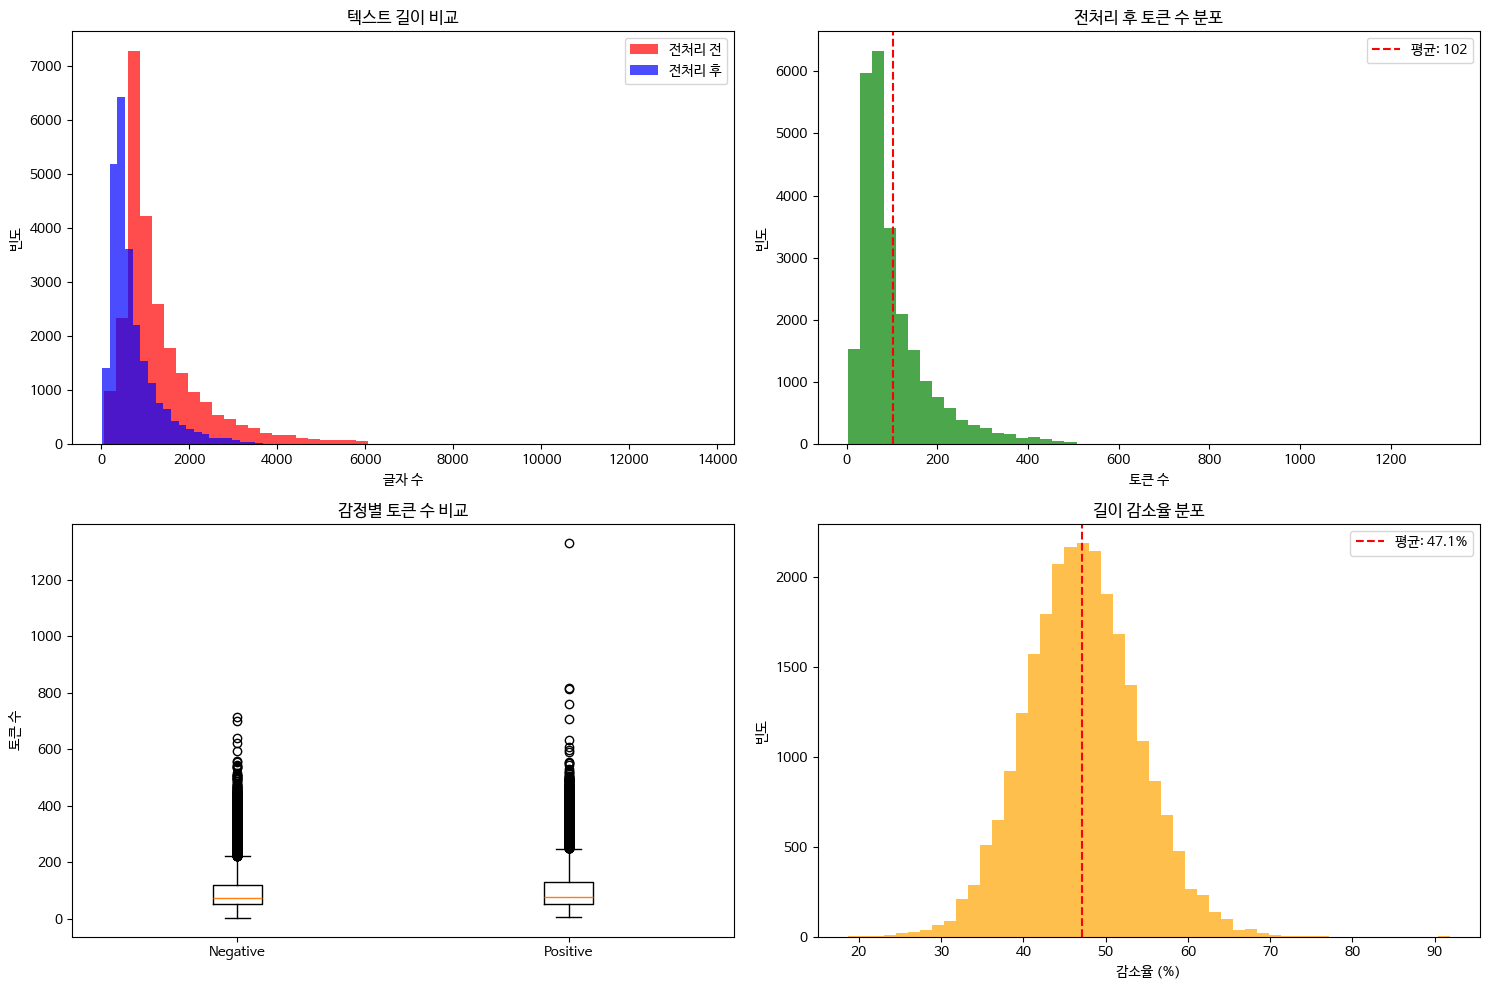


📝 전처리 전후 비교 예시

📄 예시 1:
🔸 원본 (길이: 1640자):
   I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev...
🔹 전처리 후 (길이: 867자, 토큰: 121개):
   rented curious yellow video store controversy surrounded released heard seized custom ever tried enter country therefore fan considered controversial centered around young swedish drama student named ...
🔸 토큰 (첫 15개):
   ['rented', 'curious', 'yellow', 'video', 'store', 'controversy', 'surrounded', 'released', 'heard', 'seized', 'custom', 'ever', 'tried', 'enter', 'country']

📄 예시 2:
🔸 원본 (길이: 1294자):
   "I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that ...
🔹 전처리 후 (길이: 769자, 토큰: 106개):
   curious yellow risible pretentious steaming pile matter political view h

In [33]:
# 결과 분석
analyze_preprocessing_results(train_df, train_processed)

# 예시 확인
show_preprocessing_examples(train_df, train_processed)

# 어휘 변화 분석
analyze_vocabulary_changes(train_df, train_processed)

관용어들 제거를 통해 빈번한 단어 순위가 많이 바뀌었다.

html 문법도 제거와 문장 길이 조정을 통해 질좋은 데이터가 되었다.


In [34]:
# 전역 변수로 저장
globals()['imdb_train_processed'] = train_processed
globals()['imdb_test_processed'] = test_processed

# 딥러닝 초게 세팅 및 데이터 추가 확인

In [55]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
# 텍스트 전처리 (Keras 토크나이저 사용 - 간편함)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import time
from tqdm import tqdm

In [36]:
print("🔥 IMDB 감정분석 - PyTorch RNN 모델")
print("=" * 50)
print(f"PyTorch 버전: {torch.__version__}")

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f}GB")

🔥 IMDB 감정분석 - PyTorch RNN 모델
PyTorch 버전: 2.6.0+cu124
사용 디바이스: cuda
GPU: Tesla T4
GPU 메모리: 14.7GB


In [37]:
try:
    train_df = train_processed.copy()
    test_df = test_processed.copy()
    print(f"✅ 전처리된 데이터 로드 완료")
    print(f"   훈련 데이터: {len(train_df):,}개")
    print(f"   테스트 데이터: {len(test_df):,}개")

    # 빈 텍스트 제거
    train_df = train_df[train_df['processed_text'].str.strip() != '']
    test_df = test_df[test_df['processed_text'].str.strip() != '']

    print(f"✅ 정제 후 데이터:")
    print(f"   훈련 데이터: {len(train_df):,}개")
    print(f"   테스트 데이터: {len(test_df):,}개")

    # 샘플 확인
    print(f"\n📝 샘플 데이터:")
    for i in range(2):
        text = train_df.iloc[i]['processed_text']
        label = train_df.iloc[i]['label']
        sentiment = "Positive" if label == 1 else "Negative"
        print(f"   {i+1}. {text[:80]}... → {sentiment}")

except NameError:
    print("❌ Step 2를 먼저 실행하여 전처리된 데이터를 준비하세요.")

✅ 전처리된 데이터 로드 완료
   훈련 데이터: 25,000개
   테스트 데이터: 25,000개
✅ 정제 후 데이터:
   훈련 데이터: 25,000개
   테스트 데이터: 25,000개

📝 샘플 데이터:
   1. rented curious yellow video store controversy surrounded released heard seized c... → Negative
   2. curious yellow risible pretentious steaming pile matter political view hardly ta... → Negative


# 텍스트 시퀀스화

In [38]:
print("\n📊 텍스트 시퀀스화")
print("=" * 40)

# 하이퍼파라미터 설정
MAX_VOCAB_SIZE = 10000     # 최대 어휘 사전 크기
MAX_SEQUENCE_LENGTH = 200  # 최대 시퀀스 길이
EMBEDDING_DIM = 128        # 임베딩 차원

print(f"🔧 설정:")
print(f"   최대 어휘 사전 크기: {MAX_VOCAB_SIZE:,}")
print(f"   최대 시퀀스 길이: {MAX_SEQUENCE_LENGTH}")
print(f"   임베딩 차원: {EMBEDDING_DIM}")

# 텍스트 데이터 준비
train_texts = train_df['processed_text'].tolist()
test_texts = test_df['processed_text'].tolist()
y_train = train_df['label'].values
y_test = test_df['label'].values

print(f"\n🔄 토큰화 중...")

# 토크나이저 초기화 및 학습
tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    oov_token='<OOV>',
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
)

tokenizer.fit_on_texts(train_texts)

# 텍스트를 시퀀스로 변환
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# 패딩 (모든 시퀀스를 같은 길이로)
X_train = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# 실제 어휘 사전 크기
vocab_size = min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE)

print(f"✅ 시퀀스화 완료!")
print(f"   실제 어휘 사전 크기: {vocab_size:,}")
print(f"   훈련 데이터 크기: {X_train.shape}")
print(f"   테스트 데이터 크기: {X_test.shape}")

# PyTorch 텐서로 변환
X_train_tensor = torch.LongTensor(X_train)
X_test_tensor = torch.LongTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_test_tensor = torch.FloatTensor(y_test)

print(f"✅ PyTorch 텐서 변환 완료!")


📊 텍스트 시퀀스화
🔧 설정:
   최대 어휘 사전 크기: 10,000
   최대 시퀀스 길이: 200
   임베딩 차원: 128

🔄 토큰화 중...
✅ 시퀀스화 완료!
   실제 어휘 사전 크기: 10,000
   훈련 데이터 크기: (25000, 200)
   테스트 데이터 크기: (25000, 200)
✅ PyTorch 텐서 변환 완료!


# 데이터셋 및 데이터로더 생성

In [39]:
print("\n📦 Dataset 및 DataLoader 생성")
print("=" * 40)

class IMDBDataset(Dataset):
    """IMDB 데이터셋 클래스"""
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# 데이터셋 생성
train_dataset = IMDBDataset(X_train_tensor, y_train_tensor)
test_dataset = IMDBDataset(X_test_tensor, y_test_tensor)

# 검증 데이터 분할 (훈련 데이터의 20%)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

print(f"📊 데이터 분할:")
print(f"   훈련: {len(train_dataset):,}개")
print(f"   검증: {len(val_dataset):,}개")
print(f"   테스트: {len(test_dataset):,}개")

# DataLoader 생성
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ DataLoader 생성 완료! (배치 크기: {BATCH_SIZE})")


📦 Dataset 및 DataLoader 생성
📊 데이터 분할:
   훈련: 20,000개
   검증: 5,000개
   테스트: 25,000개
✅ DataLoader 생성 완료! (배치 크기: 128)


# LSTM 모델링

In [40]:
print("\n🏗️ LSTM 모델 정의")
print("=" * 30)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                           dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 임베딩
        embedded = self.embedding(x)

        # LSTM
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # 마지막 hidden state 사용
        output = self.dropout(hidden[-1])
        output = F.relu(self.fc1(output))
        output = self.dropout(output)
        output = self.fc2(output)
        output = self.sigmoid(output)

        return output.squeeze()

# LSTM 모델 생성
lstm_model = LSTMModel(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=128,
    output_dim=1,
    n_layers=2,
    dropout=0.2
).to(device)

# 모델 정보 출력
total_params = sum(p.numel() for p in lstm_model.parameters())
trainable_params = sum(p.numel() for p in lstm_model.parameters() if p.requires_grad)

print(f"🔧 LSTM 모델:")
print(f"   총 파라미터: {total_params:,}")
print(f"   학습 가능 파라미터: {trainable_params:,}")
print(f"   모델 구조:")
print(lstm_model)


🏗️ LSTM 모델 정의
🔧 LSTM 모델:
   총 파라미터: 1,552,513
   학습 가능 파라미터: 1,552,513
   모델 구조:
LSTMModel(
  (embedding): Embedding(10000, 128)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


# GRU 모델링

In [45]:
print("\n🏗️ GRU 모델 정의")
print("=" * 25)

class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, dropout=0.2):
        super(GRUModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers,
                         dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 임베딩
        embedded = self.embedding(x)

        # GRU
        gru_out, hidden = self.gru(embedded)

        # 마지막 hidden state 사용
        output = self.dropout(hidden[-1])
        output = F.relu(self.fc1(output))
        output = self.dropout(output)
        output = self.fc2(output)
        output = self.sigmoid(output)

        return output.squeeze()

# GRU 모델 생성
gru_model = GRUModel(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=128,
    output_dim=1,
    n_layers=2,
    dropout=0.2
).to(device)

total_params = sum(p.numel() for p in gru_model.parameters())
print(f"🔧 GRU 모델:")
print(f"   총 파라미터: {total_params:,}")
print(f"   모델 구조:")
print(gru_model)


🏗️ GRU 모델 정의
🔧 GRU 모델:
   총 파라미터: 1,486,465
   모델 구조:
GRUModel(
  (embedding): Embedding(10000, 128)
  (gru): GRU(128, 128, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


# 양방향 LSTM 모델링

In [41]:
print("\n🏗️ 양방향 LSTM 모델 정의")
print("=" * 40)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, dropout=0.2):
        super(BiLSTMModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                             dropout=dropout, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        # 양방향이므로 hidden_dim * 2
        self.fc1 = nn.Linear(hidden_dim * 2, 64)
        self.fc2 = nn.Linear(64, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 임베딩
        embedded = self.embedding(x)

        # 양방향 LSTM
        bilstm_out, (hidden, cell) = self.bilstm(embedded)

        # 양방향의 마지막 hidden state 연결
        # forward와 backward의 마지막 hidden state를 concatenate
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)

        output = self.dropout(hidden)
        output = F.relu(self.fc1(output))
        output = self.dropout(output)
        output = self.fc2(output)
        output = self.sigmoid(output)

        return output.squeeze()

# 양방향 LSTM 모델 생성
bilstm_model = BiLSTMModel(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=64,  # 양방향이므로 절반 크기 사용
    output_dim=1,
    n_layers=2,
    dropout=0.2
).to(device)

total_params = sum(p.numel() for p in bilstm_model.parameters())
print(f"🔧 양방향 LSTM 모델:")
print(f"   총 파라미터: {total_params:,}")
print(f"   모델 구조:")
print(bilstm_model)


🏗️ 양방향 LSTM 모델 정의
🔧 양방향 LSTM 모델:
   총 파라미터: 1,486,977
   모델 구조:
BiLSTMModel(
  (embedding): Embedding(10000, 128)
  (bilstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


# 학습 및 평가

In [42]:
print("\n⚙️ 학습 및 평가 함수 정의")
print("=" * 40)

def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    """모델 학습 함수"""
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5, verbose=True)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    best_val_acc = 0
    best_model_state = None

    for epoch in range(epochs):
        # 훈련 모드
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for batch_x, batch_y in train_pbar:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()

            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100 * train_correct / train_total:.2f}%'
            })

        # 검증 모드
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()

        # 평균 계산
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        # 기록
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # 최고 성능 모델 저장
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()

        # 스케줄러 업데이트
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # 최고 성능 모델 복원
    model.load_state_dict(best_model_state)

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }

def evaluate_model(model, test_loader):
    """모델 평가 함수"""
    model.eval()
    all_predictions = []
    all_probabilities = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in tqdm(test_loader, desc='Testing'):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)

            all_probabilities.extend(outputs.cpu().numpy())
            all_predictions.extend((outputs > 0.5).cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    return {
        'accuracy': accuracy,
        'predictions': np.array(all_predictions),
        'probabilities': np.array(all_probabilities),
        'labels': np.array(all_labels)
    }

print("✅ 학습 및 평가 함수 정의 완료!")


⚙️ 학습 및 평가 함수 정의
✅ 학습 및 평가 함수 정의 완료!


# 모델학습

## LSTM

In [43]:
print("\n🚀 LSTM 모델 학습")
print("=" * 30)

start_time = time.time()

lstm_history = train_model(
    model=lstm_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10,
    lr=0.001
)

lstm_training_time = time.time() - start_time

print(f"\n✅ LSTM 학습 완료! ({lstm_training_time:.2f}초)")
print(f"   최고 검증 정확도: {lstm_history['best_val_acc']:.2f}%")

# LSTM 테스트 평가
print("🔮 LSTM 테스트 평가 중...")
lstm_results = evaluate_model(lstm_model, test_loader)
print(f"📊 LSTM 테스트 정확도: {lstm_results['accuracy']:.4f}")


🚀 LSTM 모델 학습


Epoch 1/10 [Train]: 100%|██████████| 157/157 [00:04<00:00, 33.32it/s, Loss=0.6903, Acc=50.05%]


Epoch 1: Train Loss: 0.6928, Train Acc: 50.05%, Val Loss: 0.6909, Val Acc: 52.06%


Epoch 2/10 [Train]: 100%|██████████| 157/157 [00:03<00:00, 44.24it/s, Loss=0.6398, Acc=52.06%]


Epoch 2: Train Loss: 0.6866, Train Acc: 52.06%, Val Loss: 0.6879, Val Acc: 52.84%


Epoch 3/10 [Train]: 100%|██████████| 157/157 [00:03<00:00, 44.91it/s, Loss=0.7503, Acc=53.12%]


Epoch 3: Train Loss: 0.6694, Train Acc: 53.12%, Val Loss: 0.6899, Val Acc: 53.58%


Epoch 4/10 [Train]: 100%|██████████| 157/157 [00:03<00:00, 44.96it/s, Loss=0.5931, Acc=55.05%]


Epoch 4: Train Loss: 0.6446, Train Acc: 55.05%, Val Loss: 0.6973, Val Acc: 53.28%


Epoch 5/10 [Train]: 100%|██████████| 157/157 [00:03<00:00, 44.31it/s, Loss=0.4325, Acc=66.72%]


Epoch 5: Train Loss: 0.5781, Train Acc: 66.72%, Val Loss: 0.5494, Val Acc: 74.32%


Epoch 6/10 [Train]: 100%|██████████| 157/157 [00:03<00:00, 42.45it/s, Loss=0.3151, Acc=82.03%]


Epoch 6: Train Loss: 0.4206, Train Acc: 82.03%, Val Loss: 0.4517, Val Acc: 80.86%


Epoch 7/10 [Train]: 100%|██████████| 157/157 [00:03<00:00, 42.51it/s, Loss=0.2632, Acc=86.94%]


Epoch 7: Train Loss: 0.3192, Train Acc: 86.94%, Val Loss: 0.4136, Val Acc: 83.02%


Epoch 8/10 [Train]: 100%|██████████| 157/157 [00:03<00:00, 41.09it/s, Loss=0.3715, Acc=90.33%]


Epoch 8: Train Loss: 0.2556, Train Acc: 90.33%, Val Loss: 0.4221, Val Acc: 84.40%


Epoch 9/10 [Train]: 100%|██████████| 157/157 [00:03<00:00, 43.43it/s, Loss=0.2560, Acc=92.72%]


Epoch 9: Train Loss: 0.1999, Train Acc: 92.72%, Val Loss: 0.4438, Val Acc: 84.58%


Epoch 10/10 [Train]: 100%|██████████| 157/157 [00:03<00:00, 43.83it/s, Loss=0.1526, Acc=94.52%]


Epoch 10: Train Loss: 0.1623, Train Acc: 94.52%, Val Loss: 0.4776, Val Acc: 84.60%

✅ LSTM 학습 완료! (46.26초)
   최고 검증 정확도: 84.60%
🔮 LSTM 테스트 평가 중...


Testing: 100%|██████████| 196/196 [00:01<00:00, 113.40it/s]

📊 LSTM 테스트 정확도: 0.8412


## GRU

In [46]:
print("\n🚀 GRU 모델 학습")
print("=" * 25)

start_time = time.time()

gru_history = train_model(
    model=gru_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10,
    lr=0.001
)

gru_training_time = time.time() - start_time

print(f"\n✅ GRU 학습 완료! ({gru_training_time:.2f}초)")
print(f"   최고 검증 정확도: {gru_history['best_val_acc']:.2f}%")

# GRU 테스트 평가
print("🔮 GRU 테스트 평가 중...")
gru_results = evaluate_model(gru_model, test_loader)
print(f"📊 GRU 테스트 정확도: {gru_results['accuracy']:.4f}")


🚀 GRU 모델 학습


Epoch 1/10 [Train]: 100%|██████████| 157/157 [00:02<00:00, 57.89it/s, Loss=0.6786, Acc=51.02%]


Epoch 1: Train Loss: 0.6937, Train Acc: 51.02%, Val Loss: 0.6938, Val Acc: 51.86%


Epoch 2/10 [Train]: 100%|██████████| 157/157 [00:02<00:00, 59.14it/s, Loss=0.6956, Acc=50.83%]


Epoch 2: Train Loss: 0.6898, Train Acc: 50.83%, Val Loss: 0.6904, Val Acc: 52.76%


Epoch 3/10 [Train]: 100%|██████████| 157/157 [00:02<00:00, 57.09it/s, Loss=0.6555, Acc=54.58%]


Epoch 3: Train Loss: 0.6690, Train Acc: 54.58%, Val Loss: 0.6366, Val Acc: 67.12%


Epoch 4/10 [Train]: 100%|██████████| 157/157 [00:02<00:00, 57.89it/s, Loss=0.2826, Acc=77.36%]


Epoch 4: Train Loss: 0.4952, Train Acc: 77.36%, Val Loss: 0.4323, Val Acc: 82.12%


Epoch 5/10 [Train]: 100%|██████████| 157/157 [00:02<00:00, 56.51it/s, Loss=0.3508, Acc=87.47%]


Epoch 5: Train Loss: 0.3190, Train Acc: 87.47%, Val Loss: 0.3736, Val Acc: 84.72%


Epoch 6/10 [Train]: 100%|██████████| 157/157 [00:02<00:00, 57.68it/s, Loss=0.5698, Acc=91.37%]


Epoch 6: Train Loss: 0.2348, Train Acc: 91.37%, Val Loss: 0.3787, Val Acc: 85.30%


Epoch 7/10 [Train]: 100%|██████████| 157/157 [00:02<00:00, 61.28it/s, Loss=0.1234, Acc=94.43%]


Epoch 7: Train Loss: 0.1685, Train Acc: 94.43%, Val Loss: 0.4355, Val Acc: 85.30%


Epoch 8/10 [Train]: 100%|██████████| 157/157 [00:02<00:00, 60.80it/s, Loss=0.1559, Acc=96.54%]


Epoch 8: Train Loss: 0.1172, Train Acc: 96.54%, Val Loss: 0.4857, Val Acc: 85.16%


Epoch 9/10 [Train]: 100%|██████████| 157/157 [00:02<00:00, 60.15it/s, Loss=0.0170, Acc=98.06%]


Epoch 9: Train Loss: 0.0721, Train Acc: 98.06%, Val Loss: 0.5837, Val Acc: 85.42%


Epoch 10/10 [Train]: 100%|██████████| 157/157 [00:02<00:00, 57.05it/s, Loss=0.0251, Acc=99.04%]


Epoch 10: Train Loss: 0.0469, Train Acc: 99.04%, Val Loss: 0.6139, Val Acc: 85.32%

✅ GRU 학습 완료! (29.46초)
   최고 검증 정확도: 85.42%
🔮 GRU 테스트 평가 중...


Testing: 100%|██████████| 196/196 [00:01<00:00, 162.99it/s]

📊 GRU 테스트 정확도: 0.8427


## 양방향 LSTM

In [47]:
print("\n🚀 양방향 LSTM 모델 학습")
print("=" * 40)

start_time = time.time()

bilstm_history = train_model(
    model=bilstm_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10,
    lr=0.001
)

bilstm_training_time = time.time() - start_time

print(f"\n✅ 양방향 LSTM 학습 완료! ({bilstm_training_time:.2f}초)")
print(f"   최고 검증 정확도: {bilstm_history['best_val_acc']:.2f}%")

# 양방향 LSTM 테스트 평가
print("🔮 양방향 LSTM 테스트 평가 중...")
bilstm_results = evaluate_model(bilstm_model, test_loader)
print(f"📊 양방향 LSTM 테스트 정확도: {bilstm_results['accuracy']:.4f}")


🚀 양방향 LSTM 모델 학습


Epoch 1/10 [Train]: 100%|██████████| 157/157 [00:02<00:00, 52.82it/s, Loss=0.6166, Acc=59.90%]


Epoch 1: Train Loss: 0.6607, Train Acc: 59.90%, Val Loss: 0.6091, Val Acc: 66.42%


Epoch 2/10 [Train]: 100%|██████████| 157/157 [00:02<00:00, 60.63it/s, Loss=0.4149, Acc=72.31%]


Epoch 2: Train Loss: 0.5595, Train Acc: 72.31%, Val Loss: 0.5437, Val Acc: 74.44%


Epoch 3/10 [Train]: 100%|██████████| 157/157 [00:02<00:00, 60.76it/s, Loss=0.6291, Acc=79.14%]


Epoch 3: Train Loss: 0.4643, Train Acc: 79.14%, Val Loss: 0.5210, Val Acc: 77.60%


Epoch 4/10 [Train]: 100%|██████████| 157/157 [00:02<00:00, 60.05it/s, Loss=0.3187, Acc=76.81%]


Epoch 4: Train Loss: 0.5077, Train Acc: 76.81%, Val Loss: 0.4873, Val Acc: 77.88%


Epoch 5/10 [Train]: 100%|██████████| 157/157 [00:02<00:00, 59.86it/s, Loss=0.4197, Acc=84.40%]


Epoch 5: Train Loss: 0.3760, Train Acc: 84.40%, Val Loss: 0.4469, Val Acc: 81.20%


Epoch 6/10 [Train]: 100%|██████████| 157/157 [00:02<00:00, 58.53it/s, Loss=0.1448, Acc=87.04%]


Epoch 6: Train Loss: 0.3247, Train Acc: 87.04%, Val Loss: 0.4251, Val Acc: 82.50%


Epoch 7/10 [Train]: 100%|██████████| 157/157 [00:02<00:00, 59.12it/s, Loss=0.1386, Acc=89.17%]


Epoch 7: Train Loss: 0.2890, Train Acc: 89.17%, Val Loss: 0.4202, Val Acc: 82.92%


Epoch 8/10 [Train]: 100%|██████████| 157/157 [00:02<00:00, 59.52it/s, Loss=0.1791, Acc=91.22%]


Epoch 8: Train Loss: 0.2459, Train Acc: 91.22%, Val Loss: 0.4211, Val Acc: 84.04%


Epoch 9/10 [Train]: 100%|██████████| 157/157 [00:02<00:00, 59.45it/s, Loss=0.3019, Acc=92.89%]


Epoch 9: Train Loss: 0.2097, Train Acc: 92.89%, Val Loss: 0.4225, Val Acc: 84.40%


Epoch 10/10 [Train]: 100%|██████████| 157/157 [00:02<00:00, 58.35it/s, Loss=0.1052, Acc=93.99%]


Epoch 10: Train Loss: 0.1817, Train Acc: 93.99%, Val Loss: 0.4408, Val Acc: 84.46%

✅ 양방향 LSTM 학습 완료! (28.91초)
   최고 검증 정확도: 84.46%
🔮 양방향 LSTM 테스트 평가 중...


Testing: 100%|██████████| 196/196 [00:01<00:00, 168.28it/s]

📊 양방향 LSTM 테스트 정확도: 0.8293


# 모델 성능비교

In [49]:
print("\n📊 PyTorch 모델 성능 비교")
print("=" * 50)

# 결과 정리
models_results = {
    'LSTM': {
        'accuracy': lstm_results['accuracy'],
        'training_time': lstm_training_time,
        'val_acc': lstm_history['best_val_acc'],
        'params': sum(p.numel() for p in lstm_model.parameters())
    },
    'GRU': {
        'accuracy': gru_results['accuracy'],
        'training_time': gru_training_time,
        'val_acc': gru_history['best_val_acc'],
        'params': sum(p.numel() for p in gru_model.parameters())
    },
    'Bidirectional LSTM': {
        'accuracy': bilstm_results['accuracy'],
        'training_time': bilstm_training_time,
        'val_acc': bilstm_history['best_val_acc'],
        'params': sum(p.numel() for p in bilstm_model.parameters())
    }
}

# 성능 비교표
comparison_data = []
for model_name, results in models_results.items():
    comparison_data.append({
        '모델': model_name,
        '테스트 정확도': f"{results['accuracy']:.4f}",
        '검증 정확도': f"{results['val_acc']:.2f}%",
        '학습시간': f"{results['training_time']:.1f}초",
        '파라미터 수': f"{results['params']:,}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# 최고 성능 모델
best_model_name = max(models_results.keys(), key=lambda x: models_results[x]['accuracy'])
best_accuracy = models_results[best_model_name]['accuracy']

print(f"\n🏆 최고 성능 모델: {best_model_name}")
print(f"   테스트 정확도: {best_accuracy:.4f}")


📊 PyTorch 모델 성능 비교
                모델 테스트 정확도 검증 정확도  학습시간    파라미터 수
              LSTM  0.8412 84.60% 46.3초 1,552,513
               GRU  0.8427 85.42% 29.5초 1,486,465
Bidirectional LSTM  0.8293 84.46% 28.9초 1,486,977

🏆 최고 성능 모델: GRU
   테스트 정확도: 0.8427


# 학습과정 시각화


📈 학습 과정 시각화


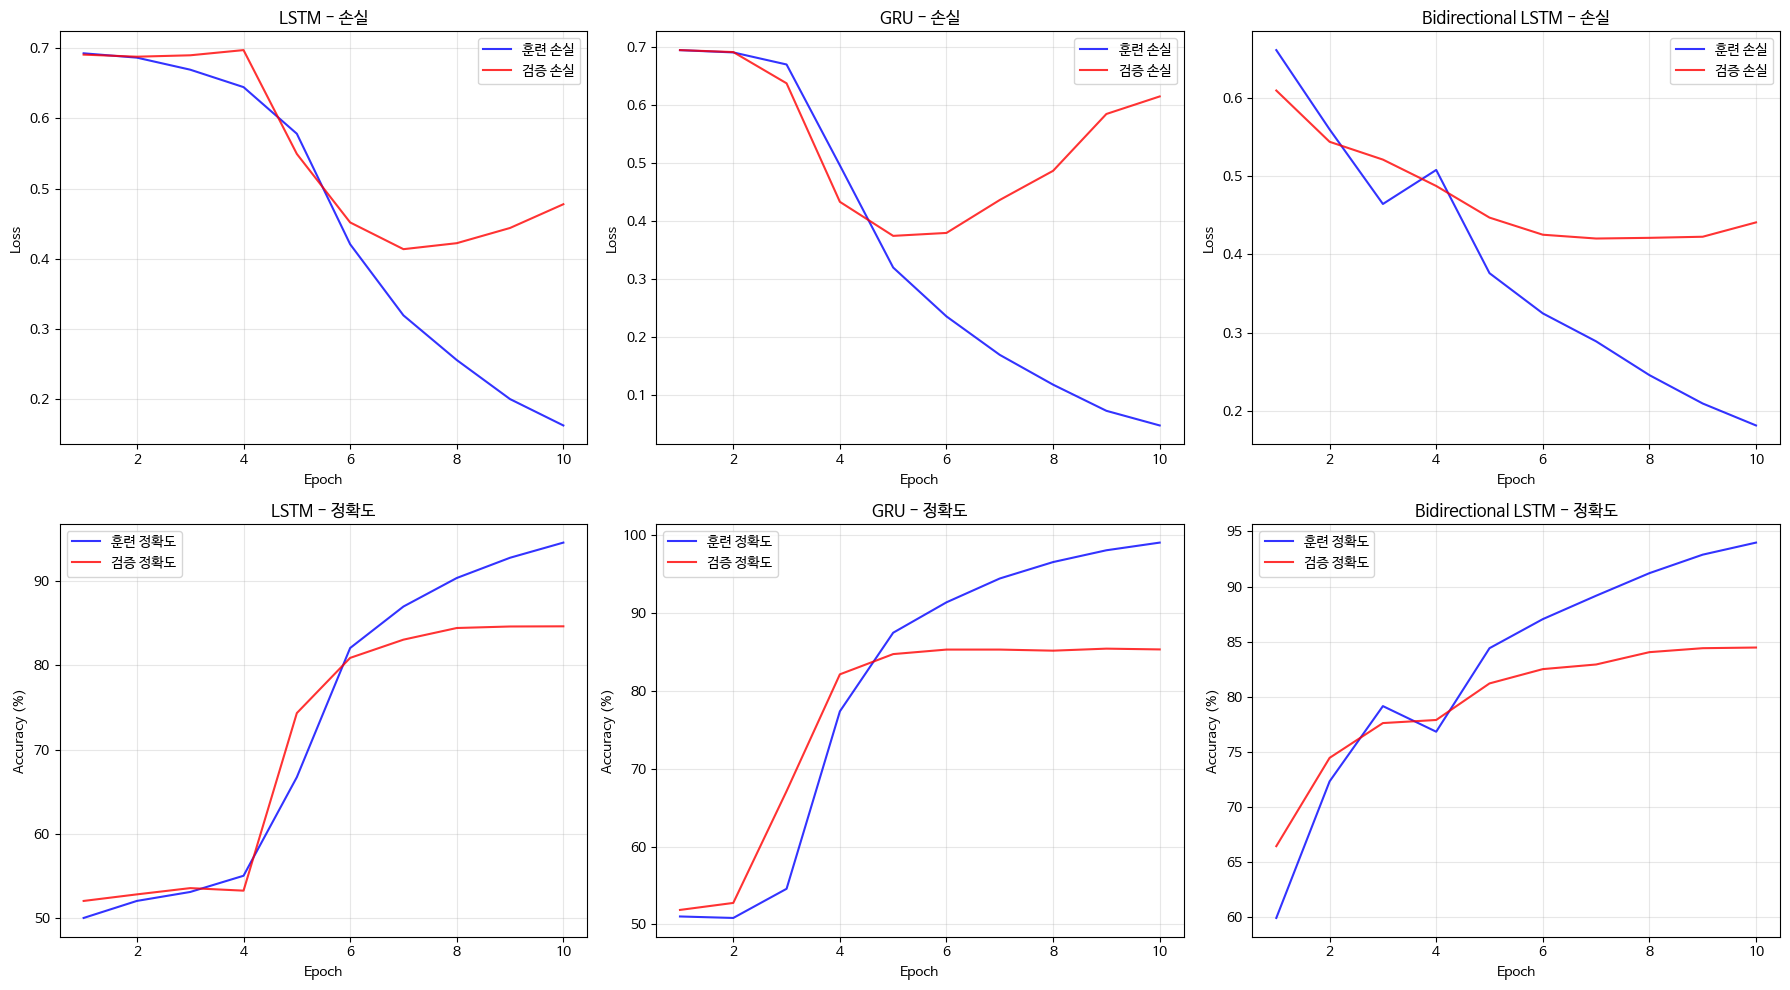

In [50]:
print("\n📈 학습 과정 시각화")
print("=" * 30)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

histories = [
    ('LSTM', lstm_history),
    ('GRU', gru_history),
    ('Bidirectional LSTM', bilstm_history)
]

for i, (model_name, history) in enumerate(histories):
    # 손실 곡선
    ax1 = axes[0, i]
    epochs_range = range(1, len(history['train_losses']) + 1)

    ax1.plot(epochs_range, history['train_losses'], 'b-', label='훈련 손실', alpha=0.8)
    ax1.plot(epochs_range, history['val_losses'], 'r-', label='검증 손실', alpha=0.8)
    ax1.set_title(f'{model_name} - 손실')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 정확도 곡선
    ax2 = axes[1, i]
    ax2.plot(epochs_range, history['train_accs'], 'b-', label='훈련 정확도', alpha=0.8)
    ax2.plot(epochs_range, history['val_accs'], 'r-', label='검증 정확도', alpha=0.8)
    ax2.set_title(f'{model_name} - 정확도')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 혼동행렬


📊 혼동 행렬


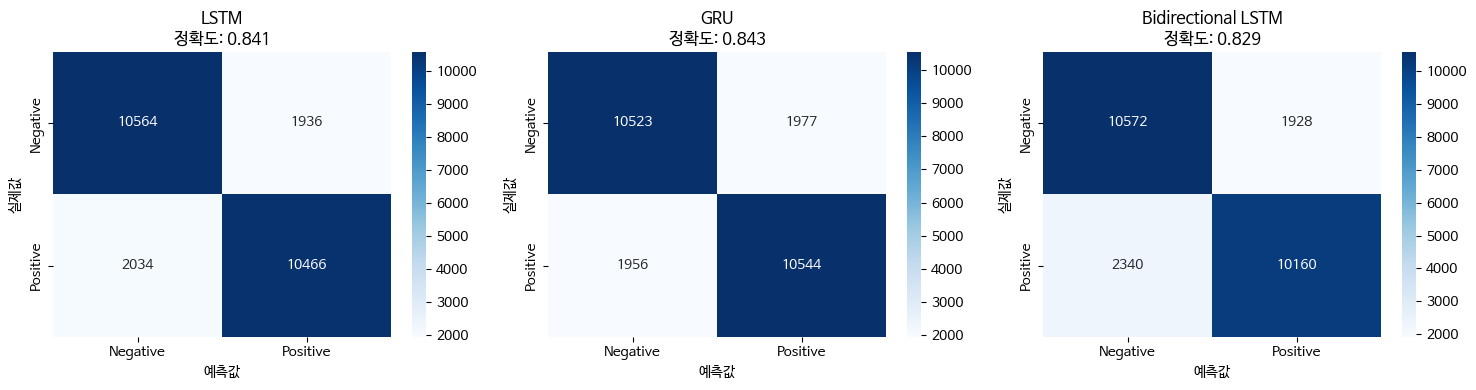

In [51]:
print("\n📊 혼동 행렬")
print("=" * 20)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

results_list = [
    ('LSTM', lstm_results),
    ('GRU', gru_results),
    ('Bidirectional LSTM', bilstm_results)
]

for i, (model_name, results) in enumerate(results_list):
    cm = confusion_matrix(results['labels'], results['predictions'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Negative', 'Positive'],
               yticklabels=['Negative', 'Positive'],
               ax=axes[i])
    axes[i].set_title(f'{model_name}\n정확도: {results["accuracy"]:.3f}')
    axes[i].set_xlabel('예측값')
    axes[i].set_ylabel('실제값')

plt.tight_layout()
plt.show()

# 실제 테스트

In [52]:
print("\n🧪 실제 예측 테스트")
print("=" * 40)

# 최고 성능 모델 선택
if best_model_name == 'LSTM':
    best_model = lstm_model
elif best_model_name == 'GRU':
    best_model = gru_model
else:
    best_model = bilstm_model

def predict_sentiment(model, tokenizer, text, max_length):
    """단일 텍스트 감정 예측"""
    model.eval()

    # 전처리 (간단히)
    text = text.lower().strip()

    # 시퀀스 변환
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post')

    # 텐서 변환
    input_tensor = torch.LongTensor(padded).to(device)

    # 예측
    with torch.no_grad():
        output = model(input_tensor)
        probability = output.item()
        prediction = 1 if probability > 0.5 else 0

    sentiment = "😊 Positive" if prediction == 1 else "😞 Negative"

    return {
        'sentiment': sentiment,
        'probability': probability,
        'confidence': max(probability, 1 - probability)
    }

# 테스트 문장들
sample_texts = [
    "This movie is absolutely fantastic! Great acting and amazing story.",
    "Terrible film. Complete waste of time and money. Very disappointed.",
    "It was okay, not great but not terrible either. Average movie.",
    "One of the best movies I've ever seen! Highly recommend it!",
    "Boring and predictable plot. Poor character development."
]

print(f"📝 {best_model_name} 모델로 예측:")

for i, text in enumerate(sample_texts, 1):
    result = predict_sentiment(best_model, tokenizer, text, MAX_SEQUENCE_LENGTH)

    print(f"\n테스트 {i}:")
    print(f"   텍스트: {text}")
    print(f"   예측: {result['sentiment']}")
    print(f"   확률: {result['probability']:.3f}")
    print(f"   신뢰도: {result['confidence']:.3f}")


🧪 실제 예측 테스트
📝 GRU 모델로 예측:

테스트 1:
   텍스트: This movie is absolutely fantastic! Great acting and amazing story.
   예측: 😊 Positive
   확률: 0.996
   신뢰도: 0.996

테스트 2:
   텍스트: Terrible film. Complete waste of time and money. Very disappointed.
   예측: 😞 Negative
   확률: 0.001
   신뢰도: 0.999

테스트 3:
   텍스트: It was okay, not great but not terrible either. Average movie.
   예측: 😞 Negative
   확률: 0.009
   신뢰도: 0.991

테스트 4:
   텍스트: One of the best movies I've ever seen! Highly recommend it!
   예측: 😊 Positive
   확률: 0.965
   신뢰도: 0.965

테스트 5:
   텍스트: Boring and predictable plot. Poor character development.
   예측: 😞 Negative
   확률: 0.003
   신뢰도: 0.997


# 최종 요약

In [54]:
print(f"\n🎉 PyTorch 감정분석 완료!")
print("=" * 50)
print(f"✅ 텍스트 시퀀스화 완료 ({vocab_size:,}개 어휘)")
print(f"✅ LSTM 모델 학습 완료 (정확도: {lstm_results['accuracy']:.4f})")
print(f"✅ GRU 모델 학습 완료 (정확도: {gru_results['accuracy']:.4f})")
print(f"✅ 양방향 LSTM 학습 완료 (정확도: {bilstm_results['accuracy']:.4f})")
print(f"✅ 최고 성능 모델: {best_model_name}")
print(f"✅ 실제 예측 테스트 완료")

print(f"\n📊 최종 성능:")
print(f"   최고 정확도: {best_accuracy:.4f}")
print(f"   GPU 사용: {'Yes' if torch.cuda.is_available() else 'No'}")

print(f"\n🎯 PyTorch로 학습한 내용:")
print("   1. PyTorch Dataset & DataLoader 사용")
print("   2. nn.Module 클래스로 모델 정의")
print("   3. 사용자 정의 학습 루프 구현")
print("   4. GPU 가속 활용")
print("   5. 3가지 RNN 아키텍처 비교")
print("   6. 실시간 학습 모니터링 (tqdm)")

print(f"\n🚀 다음 단계 제안:")
print("   - CNN 모델과 성능 비교")
print("   - 앙상블 모델 구축")
print("   - 어텐션 메커니즘 추가")
print("   - 사전 훈련된 임베딩 사용 (Word2Vec, GloVe)")


🎉 PyTorch 감정분석 완료!
✅ 텍스트 시퀀스화 완료 (10,000개 어휘)
✅ LSTM 모델 학습 완료 (정확도: 0.8412)
✅ GRU 모델 학습 완료 (정확도: 0.8427)
✅ 양방향 LSTM 학습 완료 (정확도: 0.8293)
✅ 최고 성능 모델: GRU
✅ 실제 예측 테스트 완료

📊 최종 성능:
   최고 정확도: 0.8427
   GPU 사용: Yes

🎯 PyTorch로 학습한 내용:
   1. PyTorch Dataset & DataLoader 사용
   2. nn.Module 클래스로 모델 정의
   3. 사용자 정의 학습 루프 구현
   4. GPU 가속 활용
   5. 3가지 RNN 아키텍처 비교
   6. 실시간 학습 모니터링 (tqdm)

🚀 다음 단계 제안:
   - CNN 모델과 성능 비교
   - 앙상블 모델 구축
   - 어텐션 메커니즘 추가
   - 사전 훈련된 임베딩 사용 (Word2Vec, GloVe)
